# DP 4: Drone Race
by Emily Lory and Conan Zhang

This notebook details all the code used to design, simulate, test, and plot our control system for the quadrotor navigating through an obstacle course containing 7 hoops. The system consists of a drone equipped with 4 rotors powered by an electric motor. The drone produces three net torques and a net force in the z-direction. The goal is to implement a controller-observer system that applies state feedback to the drone to navigate it through the course, while reaching desired positions and avoiding obstacles and other drones.

The first step to take is to import all the packages needed. Numpy, Sympy, Scipy help with matrix manipulation and finding our eigenvalues. They are also necessary deriving the equations of motion of the system. The quadrotor project is imported from the ae353_quadrotor module used to simulate, render, and plot the quadrotor dynamic system. Plots are created using matplotlib.pyplot. 

In [65]:
# Imports
from sympy import * 
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import ae353_quadrotor
from ae353_quadrotor import get_gravity # Obtains the gravity in m/s^2
planet = "Earth"
grav = get_gravity(planet, verbose=True) 
init_printing() # This function makes the outputs of SymPy look neater and easier to read

Next the system constants (system parameters) and variables must be defined.

In [55]:
# Mass and moment of inertia of the bus
mass = 0.5    # The mass of the quadrotor in kg
Ixx = 0.0023  # The moment of inertia of the quadrotor in 
Iyy = 0.0023  # The mass of the quadrotor in kg
Izz = 0.0040  # The mass of the quadrotor in kg
lxy = 0.25    # The x or y distance from the quadrotor frame to the mocap markers in meters
lz = 0.046875 # The z distance from the quadrotor frame to the mocap markers in meters

In [64]:
px_inW, py_inW, pz_inW = symbols('p_x, p_y, p_z')             # Defines position
vx_inB, vy_inB, vz_inB = symbols('v_x, v_y, v_z')             # Defines velocity
phi, theta, psi = symbols('phi, theta, psi')                  # Defines roll (phi), pitch (theta), and yaw (psi) angles
wx_inB, wy_inB, wz_inB = symbols('omega_x, omega_y, omega_z') # Defines angular velocities

# Defines roll, pitch, and yaw rotation matrices that describe the bus's orientation in the world frame
taux_inB, tauy_inB, tauz_inB, fz_inB = symbols('tau_x, tau_y, tau_z, f_z')

## Dynamic Model Creation

The equations for the dynamic and sensor model are then derived using Coordinate Transformations, Vector & Matrix Manipulation, Euler's Equations, Newton's Laws, and Differential Equations.

In [67]:
#rotation matrices that define the orientation of the quadrotor in the world coordinate system
p_inW = Matrix([[px_inW],[py_inW], [pz_inW]]) 
v_inB = Matrix([[vx_inB],[vy_inB],[vz_inB]])
w_inB = Matrix([[wx_inB],[wy_inB], [wz_inB]])
Rx = Matrix([[1,0,0],[0, cos(phi), -sin(phi)],[0, sin(phi),  cos(phi)]])
Ry = Matrix([[ cos(theta), 0, sin(theta)],[0, 1,0], [-sin(theta), 0, cos(theta)]])
Rz = Matrix([[cos(psi), -sin(psi), 0],[sin(psi),  cos(psi), 0],[0,0,1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T

In [68]:
# Obtains the net torque vector
tau_inB = Matrix([[taux_inB],[tauy_inB],[tauz_inB]])
tau_inB = simplify(tau_inB)

# Obtains the gravity force and convert to body coordiantes
grav_inW = Matrix([[0.],[0.],[-mass * grav]])
grav_inB = R_ofW_inB @ grav_inW

# Obtains the net force vector
f_inB = grav_inB + Matrix([[0.],[0.],[fz_inB]])
f_inB = simplify(f_inB)

In [69]:
# Assembles the moment of inertia matrix
I_inB = Matrix([[Ixx, 0.,  0.],[0.,  Iyy, 0.],[0.,  0.,  Izz]])

In [70]:
# Converts the body-fixed velocity to world-fixed velocity to get the derivatives of position
v_inW = R_ofB_inW @ v_inB
xyz_dot = simplify(v_inW)
print("px, py, pz rate as a function of orientation and body-fixed velocities:")
N(xyz_dot,3)

px, py, pz rate as a function of orientation and body-fixed velocities:


⎡vₓ⋅cos(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + v_z⋅(sin(φ)⋅s
⎢                                                                             
⎢vₓ⋅sin(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)) - v_z⋅(sin(φ)⋅c
⎢                                                                             
⎣                            -vₓ⋅sin(θ) + v_y⋅sin(φ)⋅cos(θ) + v_z⋅cos(φ)⋅cos(θ

in(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ))⎤
                             ⎥
os(ψ) - sin(ψ)⋅sin(θ)⋅cos(φ))⎥
                             ⎥
)                            ⎦

In [71]:
# Applies Newton's Second Law to get the derivative of the velocity in body-fixed coordinates
v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
v_inB_dot = simplify(v_inB_dot)
print("Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:")
N(v_inB_dot,3)

Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:


⎡       -ω_y⋅v_z + 1.0⋅ω_z⋅v_y + 9.81⋅sin(θ)       ⎤
⎢                                                  ⎥
⎢     1.0⋅ωₓ⋅v_z - ω_z⋅vₓ - 9.81⋅sin(φ)⋅cos(θ)     ⎥
⎢                                                  ⎥
⎣2.0⋅f_z - ωₓ⋅v_y + 1.0⋅ω_y⋅vₓ - 9.81⋅cos(φ)⋅cos(θ)⎦

In [63]:
# Defines the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Inverts the transformation to get a matrix that takes body-fixed angular rates to roll, pitch, and yaw rates
M_inv = simplify(M.inv())

# Converts the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = simplify(M_inv@w_inB)
print("Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:")
N(rpy_dot,3)

Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:


⎡ωₓ + ω_y⋅sin(φ)⋅tan(θ) + ω_z⋅cos(φ)⋅tan(θ)⎤
⎢                                          ⎥
⎢         ω_y⋅cos(φ) - ω_z⋅sin(φ)          ⎥
⎢                                          ⎥
⎢         ω_y⋅sin(φ) + ω_z⋅cos(φ)          ⎥
⎢         ───────────────────────          ⎥
⎣                  cos(θ)                  ⎦

In [72]:
# Applies Euler's equation to get the time derivative of the angular velocities of the quadrotor in the quadrotor frame
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = simplify(w_inB_dot)
print("Time derivative of the angular velocities in the body-fixed frame:")
N(w_inB_dot, 3)

Time derivative of the angular velocities in the body-fixed frame:


⎡-0.739⋅ω_y⋅ω_z + 435.0⋅τₓ⎤
⎢                         ⎥
⎢0.739⋅ωₓ⋅ω_z + 435.0⋅τ_y ⎥
⎢                         ⎥
⎣        250.0⋅τ_z        ⎦

In [73]:
# Assembles all differential equations
f = Matrix.vstack(xyz_dot,
                      v_inB_dot,
                      rpy_dot,
                      w_inB_dot)

In [74]:
N(f,3)

⎡vₓ⋅cos(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + v_z⋅(sin(φ)⋅s
⎢                                                                             
⎢vₓ⋅sin(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)) - v_z⋅(sin(φ)⋅c
⎢                                                                             
⎢                            -vₓ⋅sin(θ) + v_y⋅sin(φ)⋅cos(θ) + v_z⋅cos(φ)⋅cos(θ
⎢                                                                             
⎢                                   -ω_y⋅v_z + 1.0⋅ω_z⋅v_y + 9.81⋅sin(θ)      
⎢                                                                             
⎢                                 1.0⋅ωₓ⋅v_z - ω_z⋅vₓ - 9.81⋅sin(φ)⋅cos(θ)    
⎢                                                                             
⎢                            2.0⋅f_z - ωₓ⋅v_y + 1.0⋅ω_y⋅vₓ - 9.81⋅cos(φ)⋅cos(θ
⎢                                                                             
⎢                                ωₓ + ω_y⋅sin(φ)⋅tan

The equations of motion for the dynamic model are now in the form:

$$\begin{bmatrix} \dot{p_x} \\ \dot{p_y} \\ \dot{p_z} \\ \dot{v_x} \\ \dot{v_y} \\ \dot{v_z} \\ \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{\omega_x} \\ \dot{\omega_y} \\ \dot{\omega_z} \end{bmatrix}=f\left(p_x, p_y, p_z, v_x, v_y, v_z, \phi, \theta, \psi, \omega_x, \omega_y, \omega_z, \tau_x, \tau_y, \tau_z, f_z\right)$$

Here is the function $f$:

## Sensor Model Creation

In [77]:
# Position of markers in body frame
mark1_inB = Matrix([[lxy],[0.],[lz]])
mark2_inB = Matrix([[0.],[lxy],[lz]])
mark3_inB = Matrix([[-lxy],[0.],[lz]])
mark4_inB = Matrix([[0.],[-lxy],[lz]])

# Position of markers in world frame
mark1_inW = p_inW + R_ofB_inW @ mark1_inB
mark2_inW = p_inW + R_ofB_inW @ mark2_inB
mark3_inW = p_inW + R_ofB_inW @ mark3_inB
mark4_inW = p_inW + R_ofB_inW @ mark4_inB

# Sensor model
g = simplify(Matrix.vstack(mark1_inW, mark2_inW, mark3_inW, mark4_inW))

In [78]:
# Obtains the sensor model
N(g,3)

⎡              pₓ + 0.0469⋅sin(φ)⋅sin(ψ) + 0.0469⋅sin(θ)⋅cos(φ)⋅cos(ψ) + 0.25⋅
⎢                                                                             
⎢              p_y - 0.0469⋅sin(φ)⋅cos(ψ) + 0.0469⋅sin(ψ)⋅sin(θ)⋅cos(φ) + 0.25
⎢                                                                             
⎢                                p_z - 0.25⋅sin(θ) + 0.0469⋅cos(φ)⋅cos(θ)     
⎢                                                                             
⎢pₓ + 0.0469⋅sin(φ)⋅sin(ψ) + 0.25⋅sin(φ)⋅sin(θ)⋅cos(ψ) - 0.25⋅sin(ψ)⋅cos(φ) + 
⎢                                                                             
⎢p_y + 0.25⋅sin(φ)⋅sin(ψ)⋅sin(θ) - 0.0469⋅sin(φ)⋅cos(ψ) + 0.0469⋅sin(ψ)⋅sin(θ)
⎢                                                                             
⎢                             p_z + 0.25⋅sin(φ)⋅cos(θ) + 0.0469⋅cos(φ)⋅cos(θ) 
⎢                                                                             
⎢              pₓ + 0.0469⋅sin(φ)⋅sin(ψ) + 0.0469⋅si

The sensor model is now in the form:
$$
\begin{bmatrix}
{m_1}_x \\ 
{m_1}_y \\ 
{m_1}_z \\ 
{m_2}_x \\ 
{m_2}_y \\ 
{m_2}_z \\
{m_3}_x \\ 
{m_3}_y \\ 
{m_3}_z \\ 
{m_4}_x \\ 
{m_4}_y \\ 
{m_4}_z \\
\end{bmatrix}= g(p_x, p_y, p_z, \phi, \theta, \psi),
$$
where ${m_i}_j$ is the $j$ coordinate of the $i$th marker in world coordinates

## System Linearization and State Space Form

Beginning the linearization process, equilibrium points are first defined. Choosing desirable equilibrium points of 0 asides from the net force in the z-axis = 4.905, the controller can stabilize by countering the force of gravity with its own net force. The equilibrium points chosen indeed work as the dynamic model function is entirely equal to zero after plugging the points in.

In [75]:
# Obtains equilibrium points
px_e = py_e = pz_e = vx_e = vy_e = vz_e = phi_e = theta_e = psi_e = omegax_e = omegay_e = omegaz_e = taux_e = tauy_e = tauz_e = 0.
fz_e = 4.905

m_e = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
n_e = np.array([0, 0, 0, 4.905])

In [76]:
# Checks if the function value when plugging the equilibrium points equals to 0
f_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], f)
f_eq = f_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
Matrix(f_eq)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

Solving for the A and B matrices by taking the Jacobian of the dynamic model function with respect to the state and input variables, A is a 12x12 matrix and B is a 12x4 matrix. The system is now placed into state-space form.

In [18]:
# Solving for Coefficient Matrix A
A_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], 
                 f.jacobian([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB]))
A = A_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
print(A.shape)
Matrix(A)

(12, 12)


⎡0  0  0  1.0   0    0     0     0    0   0    0    0 ⎤
⎢                                                     ⎥
⎢0  0  0   0   1.0   0     0     0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0   1.0    0     0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0    9.81  0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0   -9.81   0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0  1.0   0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0   0   1.0   0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0   0    0   1.0⎥
⎢                                               

In [19]:
# Solving for Coefficient Matrix B
B_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], 
                 f.jacobian([taux_inB, tauy_inB, tauz_inB, fz_inB]))
B = B_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
print(B.shape)
Matrix(B)

(12, 4)


⎡       0                 0            0     0 ⎤
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0    2.0⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢434.782608695652         0            0     0 ⎥
⎢                                              ⎥
⎢       0          4

Checking the controllability of the state-space model, the rank of the controllability matrix equals the number of states. The model is thus controllable.

In [20]:
# Checking Controllability
n = A.shape[0]
Wc = B
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    Wc = np.block([Wc, col])
print(Wc.shape)
print(np.linalg.matrix_rank(Wc) == n)

(12, 48)
True


By plugging the chosen equilibrium points into the sensor model, the equilibrium marker coordinates for the sensor model can be derived for.

In [21]:
# Solving for equilibrium matrix g
g_eq = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], g)
g_eq = g_eq(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
g_eq = g_eq.reshape(12,)
print(g_eq.shape)
Matrix(g_eq)

(12,)


⎡  0.25  ⎤
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢  0.25  ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢ -0.25  ⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢ -0.25  ⎥
⎢        ⎥
⎣0.046875⎦

Solving for the C and D matrices by taking the Jacobian of the sensor model function with respect to the state and input variables, C is a 12x12 matrix and D is a 12x4 matrix. Matrix D is full of zeros because the sensor model does not depend on the control input variables. The observer is now placed into state-space form.

In [22]:
# Solving for Coefficient Matrix C
C_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], 
                 g.jacobian([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB]))
C = C_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
print(C.shape)
Matrix(C)

(12, 12)


⎡1.0   0    0   0  0  0      0      0.046875    0    0  0  0⎤
⎢                                                           ⎥
⎢ 0   1.0   0   0  0  0  -0.046875     0      0.25   0  0  0⎥
⎢                                                           ⎥
⎢ 0    0   1.0  0  0  0      0       -0.25      0    0  0  0⎥
⎢                                                           ⎥
⎢1.0   0    0   0  0  0      0      0.046875  -0.25  0  0  0⎥
⎢                                                           ⎥
⎢ 0   1.0   0   0  0  0  -0.046875     0        0    0  0  0⎥
⎢                                                           ⎥
⎢ 0    0   1.0  0  0  0    0.25        0        0    0  0  0⎥
⎢                                                           ⎥
⎢1.0   0    0   0  0  0      0      0.046875    0    0  0  0⎥
⎢                                                           ⎥
⎢ 0   1.0   0   0  0  0  -0.046875     0      -0.25  0  0  0⎥
⎢                                                           ⎥
⎢ 0    0

In [23]:
# Solving for Coefficient Matrix D
D_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], 
                 g.jacobian([taux_inB, tauy_inB, tauz_inB, fz_inB]))
D = D_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
print(D.shape)
Matrix(D)

(12, 4)


⎡0  0  0  0⎤
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎣0  0  0  0⎦

Checking the observability of the state-space model, the rank of the observability matrix equals the number of states. The model is thus observable.

In [79]:
# Checking for Observability
n = np.shape(A)[0]
Wo = C
for i in range(1, n):
    col = C@np.linalg.matrix_power(A, i)
    Wo = np.block([[Wo], [col]])
print(Wo.shape)
print(np.linalg.matrix_rank(Wo) == n)

(144, 12)
True


## Gain Selection

Using the LQR method to find the gains matrices with given weights, the Q and R matrices can be varied below to achieve desirable results. Bryson's Rule was used to determine desirable weights for the drone. This design choice along with the chosen weights came about after extensive testing and simulations. 

In [81]:
def lqr(A,B,Q,R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

In [82]:
Qc = np.diag([1/(100**2), 1/(100**2), 1/(10**2), 1/(105**2), 1/(105**2), 1/(105**2), 1/(50**2), 1/(100**2), 1/(100**2), 1/(50**2), 1/(50**2), 1/(50**2)])
Rc = np.diag([1/(0.065**2),1/(0.065**2),1/(0.065**2),1/(16**2)])
K = lqr(A,B,Qc,Rc)
print(K.shape)
Matrix(K)

(4, 12)


⎡2.48838941607302e-19  -0.000649999999999996  -2.45336644918023e-17  2.5052952
⎢                                                                             
⎢0.000650000000000001  2.76255301521824e-19   -4.85433235226306e-18  0.0015400
⎢                                                                             
⎢2.1713926029619e-19   9.70809015260651e-19   2.46658928615962e-18   4.4793522
⎢                                                                             
⎣7.35829487937904e-17  9.11797240443686e-16     1.59999999999999     3.6953365

2140539e-19  -0.00154377864600639  -2.50120007078978e-17   0.0150925533438899 
                                                                              
8265695023   6.14299281544653e-19  -1.8198493649924e-19   -3.47882539390778e-1
                                                                              
5246276e-19  1.24126541962566e-18  -5.61021063406122e-19  -8.16345631549557e-1
                                                   

In [83]:
Ro = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Qo = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
L = lqr(A.T,C.T,linalg.inv(Ro),linalg.inv(Qo)).T
print(L.shape)
Matrix(L)

(12, 12)


⎡   1.6029062077909     3.42419815333575e-16    -0.190234588600967       1.602
⎢                                                                             
⎢3.45240398767894e-16     1.60290620779089     -2.33966253444588e-16   2.10888
⎢                                                                             
⎢2.98540352686844e-17   -2.18462788811759e-16    0.707106781186548    1.626554
⎢                                                                             
⎢  4.91038697468918     2.85045743565941e-15     -1.25643282154566      4.9103
⎢                                                                             
⎢1.97097322447859e-15     4.91038697468917     -1.17785918040336e-15  1.758020
⎢                                                                             
⎢-3.5376354961972e-17   -5.04661102917314e-16    0.500000000000001    2.392877
⎢                                                                             
⎢-4.0243400114525e-16    -0.828190463834783    1.249

Gain matrix K is a 4x12 matrix while Gain matrix L is a 12x12 matrix. The system is asymptotically stable if and only if all eigenvalues have a negative real part. They are all negative as seen below.

In [84]:
print(linalg.eigvals(A-B@K))
print(linalg.eigvals(A-L@C))

[-0.67722387+1.26659248j -0.67722387-1.26659248j -1.15093356+0.13888266j
 -1.15093356-0.13888266j -0.68837747+1.26361086j -0.68837747-1.26361086j
 -1.2740565 +1.25569903j -1.2740565 -1.25569903j -1.14488671+0.16787305j
 -1.14488671-0.16787305j -0.32811012+0.23418742j -0.32811012-0.23418742j]
[-1.40682801+2.17021669e+00j -1.40682801-2.17021669e+00j
 -1.40682801+2.17021669e+00j -1.40682801-2.17021669e+00j
 -2.93130819+0.00000000e+00j -2.93130819+0.00000000e+00j
 -0.55901699+4.33012702e-01j -0.55901699-4.33012702e-01j
 -1.00128528+0.00000000e+00j -1.00128528+0.00000000e+00j
 -1.41421356+4.78610025e-08j -1.41421356-4.78610025e-08j]


## Controller Design

The controller class is then created with 3 functions within. __ __init__ __ Initializes the controller with the system's starting values. __Reset__ resets the controller to an initial state. __Run__ runs the controller passing data from the simulation enviornment to the controller via kwargs, returning the inputs.


In [31]:
# Create the Controller class
class Controller():
    def __init__(self):
        # Initializing controller
        self.A = np.array(A, dtype=float)
        self.B = np.array(B, dtype=float)
        self.C = np.array(C, dtype=float)
        self.K = np.array(K, dtype=float)
        self.L = np.array(L, dtype=float)
        self.m_e = np.array([px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e])
        self.n_e = np.array([taux_e, tauy_e, tauz_e, fz_e])
        self.g_eq = g_eq
        self.e_max = 1.0
        self.phat_history = np.array([0.,0.,0.])
        self.pdes_history = np.array([0.,0.,0.])
        pass

    
    def reset(self):
        # Defining arrays for data collection
        self.xhat = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        self.phat_history = np.array([0.,0.,0.])
        self.pdes_history = np.array([0.,0.,0.])
        pass
    
    
    def run(self, **kwargs):
        # Obtaining necessary variables
        self.dt = kwargs["dt"]
        self.p_des = kwargs["next_gate"]
        self.p_dir = kwargs["dir_gate"]
        self.p_hat = self.xhat[:3]

        # Defining targeted position of gate 
        up = np.array([0,0,1])
        self.p_des = self.p_des + up
        
        # Constants
        k_attract = 10.    # ideal is 11.5
        k_repel = 1/10000       # ideal is 1.0
        k_des = 1.0        # ideal is 1.0
        r_drone = 0.8      # ideal is 0.8
        
        # Attractive Component
        h_attract = k_attract*(self.p_hat - self.p_des)/np.linalg.norm(self.p_hat - self.p_des)

        # Repulsive Component
        h_repel = 0
        for q in kwargs["pos_others"]:
            p_obst = q + r_drone*(self.p_hat - q)/np.linalg.norm(self.p_hat - q)
            grad_d = (self.p_hat - p_obst)/np.linalg.norm(self.p_hat - p_obst)
            d_p = np.linalg.norm(self.p_hat - p_obst) - r_drone
            h_repel += -k_repel*(grad_d/d_p**2)
        
        h = h_attract + h_repel
        
        # Minimizing error
        if np.linalg.norm(self.p_des - self.p_hat) < self.e_max:
            self.p_des = self.p_des
        else:
            self.p_des = self.p_hat - k_des*h
            
        self.x_des = np.block([self.p_des, np.zeros(9)])

        # Calculating gains
        u = - self.K@(self.xhat - self.x_des)
        inputs = u + self.n_e
            
        # Last gate condition
        if kwargs["is_last_gate"]:
            inputs = inputs*1.1
        
        # Updating state estimate
        sensor = np.block([kwargs["mocap_1"], kwargs["mocap_2"], kwargs["mocap_3"], kwargs["mocap_4"]])
        y = sensor - self.g_eq
        self.xhat += self.dt * (self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat - y))

        # Updating observer history
        self.phat_history = np.block([[self.phat_history], [self.xhat[:3]]])
        self.pdes_history = np.block([[self.pdes_history], [self.p_des]])
        
        return inputs

# Creates an instance of the Controller class to simulate a quadrotor
controller = Controller()

## Simulations

All 100 simulations were conducted with the drone initially at rest and under Earth’s gravity. The maximum simulation time was set to 30 seconds, and if the race time exceeded the maximum simulation time, the simulation ended and concluded the race. The sensor noise was set to 0.01 meters. The controller is first initialized, then reset, then ran in each iteration to track the stats and data of the trial.

In [32]:
# Creating empty data arrays
p_est_act = np.array([])
p_des_act = np.array([])
time = np.array([])

trials = 100

# Initialize the controller
controller.__init__()
for i in range(1, trials+1):
    # Reset the simulator with initial conditions at equilibirum
    team_list = ["Team Flying Mambas"]
    sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=False,
                                    visualization=False,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=False)
    # Reset the controller
    controller.reset()
    
    # Run the simulation
    controllers = [controller]
    (track_stats, data) = sim.run(controllers,
                              sensor_noise=0.01,
                              collect_data=True,
                              max_time=30.0,
                              verbose=True)
    # Collecting data
    p_est = controller.phat_history
    p_des = controller.pdes_history
    pos = np.array(data[0]['position'])

    # Storing data into arrays
    p_est_act = np.append(p_est_act, np.sqrt(np.mean(pos - p_est[1:])**2))
    p_des_act = np.append(p_des_act, np.sqrt(np.mean(pos - p_des[1:])**2))

    # Collecting simulation run times
    if(data[0]["time"][-1] < 29):
        time = np.append(time, data[0]["time"][-1])
    else:
        time = np.append(time, 0)

Team Flying Mambas:0 PASSED GATE 1 IN 3.71s
Team Flying Mambas:0 PASSED GATE 2 IN 6.98s
Team Flying Mambas:0 PASSED GATE 3 IN 9.95s
Team Flying Mambas:0 PASSED GATE 4 IN 13.66s
Team Flying Mambas:0 PASSED GATE 5 IN 17.7s
Team Flying Mambas:0 PASSED GATE 6 IN 24.75s
Team Flying Mambas:0 PASSED GATE 7 IN 26.6s
Team Flying Mambas:0 COMPLETED LAP IN 26.6s
Team Flying Mambas:0 PASSED GATE 1 IN 3.71s
Team Flying Mambas:0 PASSED GATE 2 IN 6.98s
Team Flying Mambas:0 PASSED GATE 3 IN 9.95s
Team Flying Mambas:0 PASSED GATE 4 IN 13.65s
Team Flying Mambas:0 PASSED GATE 5 IN 17.68s
Team Flying Mambas:0 PASSED GATE 6 IN 24.74s
Team Flying Mambas:0 PASSED GATE 7 IN 26.6s
Team Flying Mambas:0 COMPLETED LAP IN 26.6s
Team Flying Mambas:0 PASSED GATE 1 IN 3.71s
Team Flying Mambas:0 PASSED GATE 2 IN 6.98s
Team Flying Mambas:0 PASSED GATE 3 IN 9.95s
Team Flying Mambas:0 PASSED GATE 4 IN 13.66s
Team Flying Mambas:0 PASSED GATE 5 IN 17.69s
Team Flying Mambas:0 PASSED GATE 6 IN 24.75s
Team Flying Mambas:0 PAS

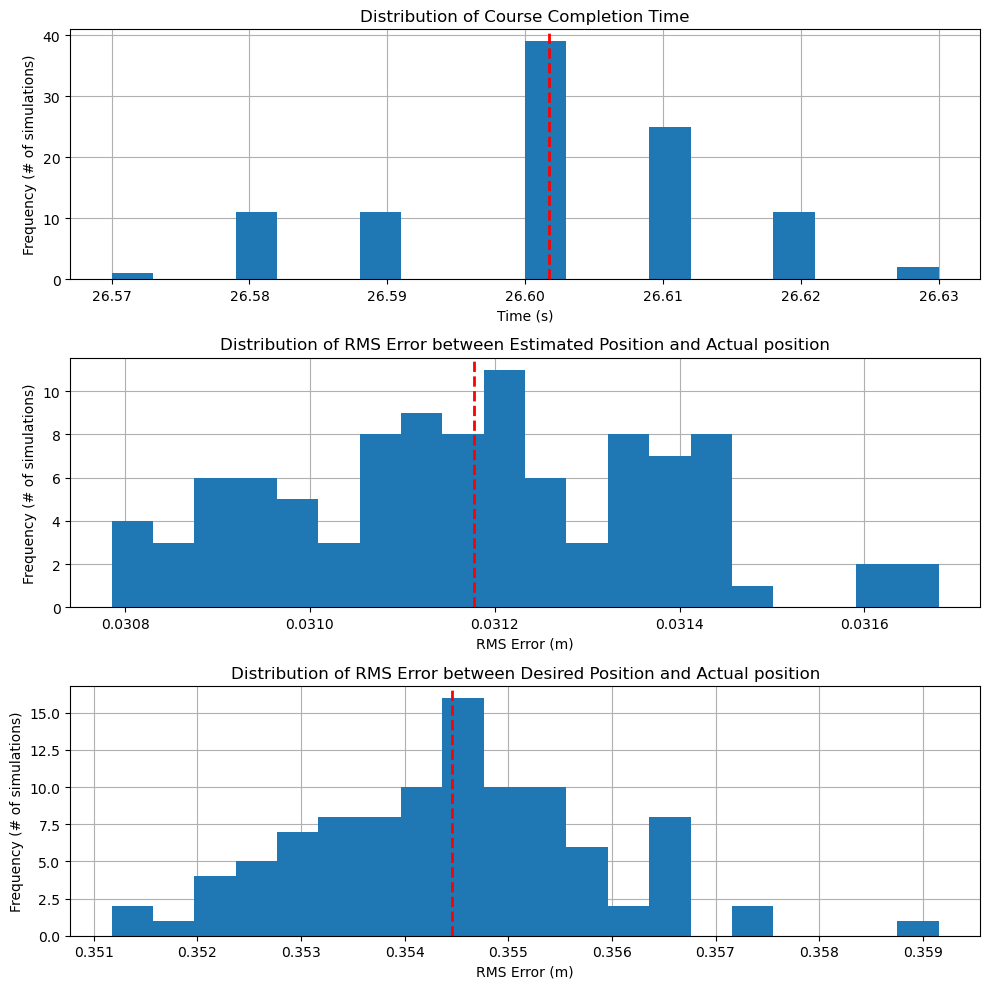

Average Simulation Run Time: 26.60170000000136
Average RMS Error Between Estimated and Actual Position: 0.03117738815597137
Average RMS Error Between Desired and Actual Position: 0.3544525818440156


In [53]:
# Setting up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10)) 

# Obtaining means of arrays
mean_time = np.mean(time)
mean_p_est_act = np.mean(p_est_act)
mean_p_des_act = np.mean(p_des_act)

# Time histogram
axs[0].hist(time, bins=20, zorder=2)
axs[0].axvline(mean_time, color='r', linestyle='dashed', linewidth=2)
axs[0].grid(zorder=0)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Frequency (# of simulations)')
axs[0].set_title('Distribution of Course Completion Time')

# Estimated vs. Actual Position RMSE histogram
axs[1].hist(p_est_act, bins=20, zorder=2)
axs[1].axvline(mean_p_est_act, color='r', linestyle='dashed', linewidth=2)
axs[1].grid(zorder=0)
axs[1].set_xlabel('RMS Error (m)')
axs[1].set_ylabel('Frequency (# of simulations)')
axs[1].set_title('Distribution of RMS Error between Estimated Position and Actual position')

# Desired vs. Actual Position RMSE histogram
axs[2].hist(p_des_act, bins=20, zorder=2)
axs[2].axvline(mean_p_des_act, color='r', linestyle='dashed', linewidth=2)
axs[2].grid(zorder=0)
axs[2].set_xlabel('RMS Error (m)')
axs[2].set_ylabel('Frequency (# of simulations)')
axs[2].set_title('Distribution of RMS Error between Desired Position and Actual position')

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.savefig('histograms-data.png', dpi=300, bbox_inches='tight')
plt.show()

print("Average Simulation Run Time:", mean_time)
print("Average RMS Error Between Estimated and Actual Position:", mean_p_est_act)
print("Average RMS Error Between Desired and Actual Position:", mean_p_des_act)

 The average course completion time was around 26.6 second  and the system had no collision with the hoopss. The RMS errors between estimated and actual position, and between desired and actual position, were minimal (0.03117 and 0.35445 meters respectively) confirming the robust nature of the observer and controller.  

In [34]:
# Gets estimated, desired, and actual position data from last simulation
p_est = p_est[1:]
p_des = p_des[1:]

# x-position data
x_est = p_est[:,0]
x_des = p_des[:,0]
x_act = pos[:,0]

# y-position data
y_est = p_est[:,1]
y_des = p_des[:,1]
y_act = pos[:,1]

# z-position data
z_est = p_est[:,2]
z_des = p_des[:,2]
z_act = pos[:,2]

# time data
time_test = np.array(data[0]["time"])

The position data can be extracted for the last instance of the 100 simulations for an array of their estimated, desired, and actual positions over time. These arrays can then be placed into plots to observe the drone's navigation. The plot for the estimated vs. actual position is displayed below for the final simulation.

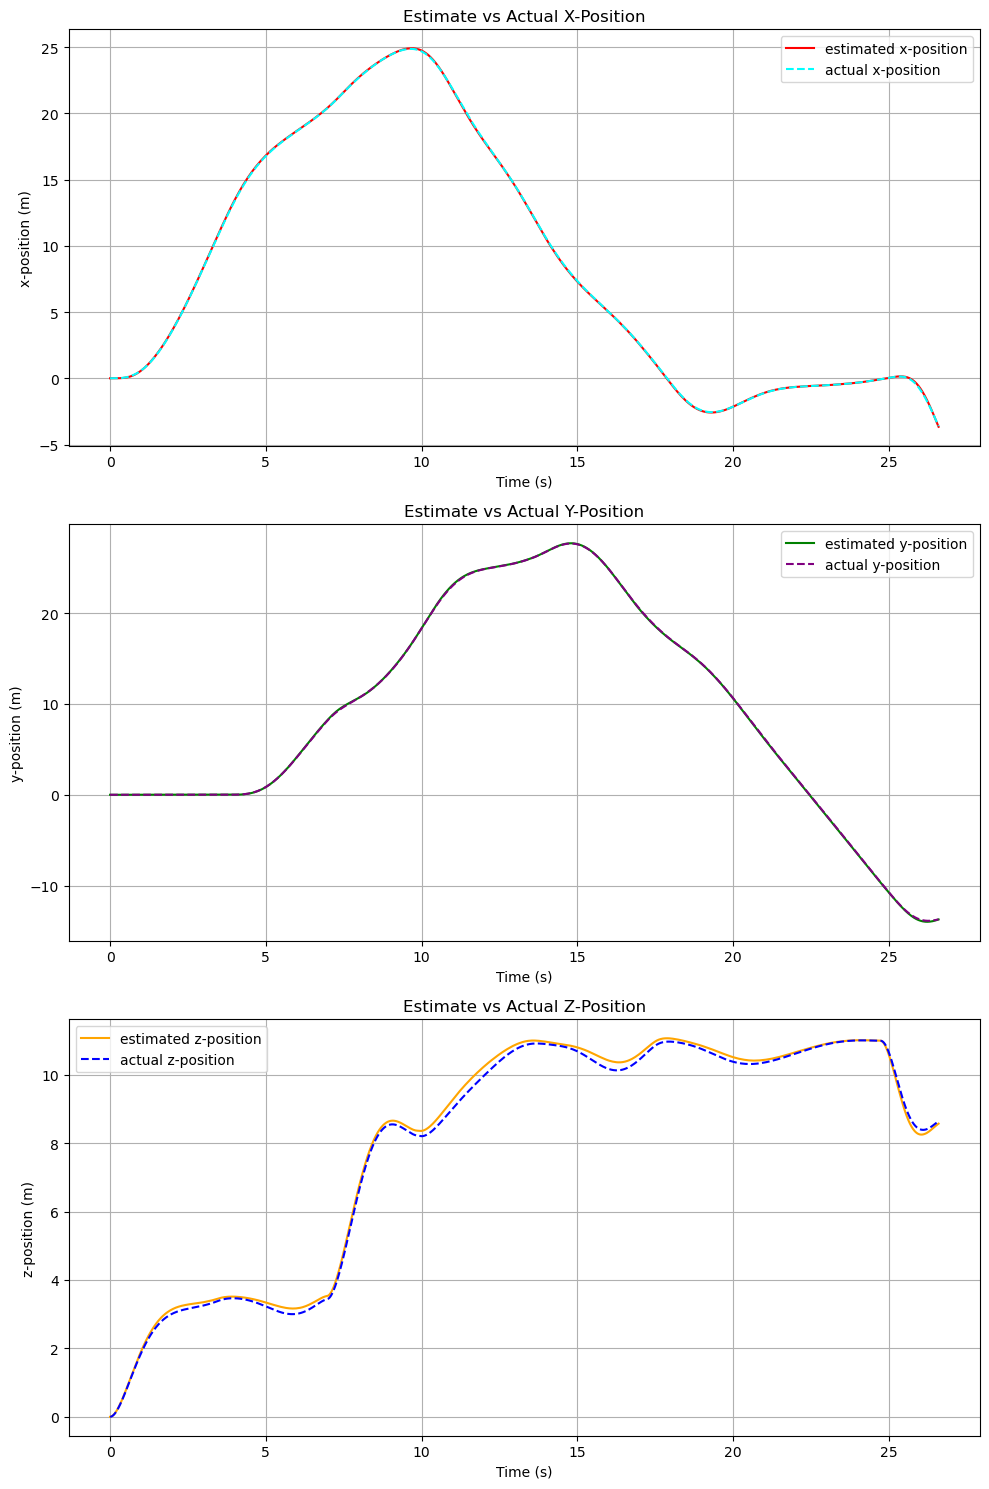

In [43]:
# Setting up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# x-position plot
axs[0].plot(time_test, x_est, label='estimated x-position', color='red')
axs[0].plot(time_test, x_act, label='actual x-position', color='cyan', linestyle='--')
axs[0].legend()
axs[0].set_title('Estimate vs Actual X-Position')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('x-position (m)')
axs[0].grid(True)

# y-position plot
axs[1].plot(time_test, y_est, label='estimated y-position', color='green')
axs[1].plot(time_test, y_act, label='actual y-position', color='purple', linestyle='--')
axs[1].legend()
axs[1].set_title('Estimate vs Actual Y-Position')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('y-position (m)')
axs[1].grid(True)

# z-position plot
axs[2].plot(time_test, z_est, label='estimated z-position', color='orange')
axs[2].plot(time_test, z_act, label='actual z-position', color='blue', linestyle='--')
axs[2].legend()
axs[2].set_title('Estimate vs Actual Z-Position')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('z-position (m)')
axs[2].grid(True)

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.savefig('est-act-pos-data.png', dpi=300, bbox_inches='tight')
plt.show()

The plots above illustrate how the estimated position and actual position of the drone vary over time. There is a signifigant overlap for the x,y,z coordinates. The sensor did an accurate job of sensing the drone's position over time. The plot for the desired vs. actual position is displayed below for the final simulation.

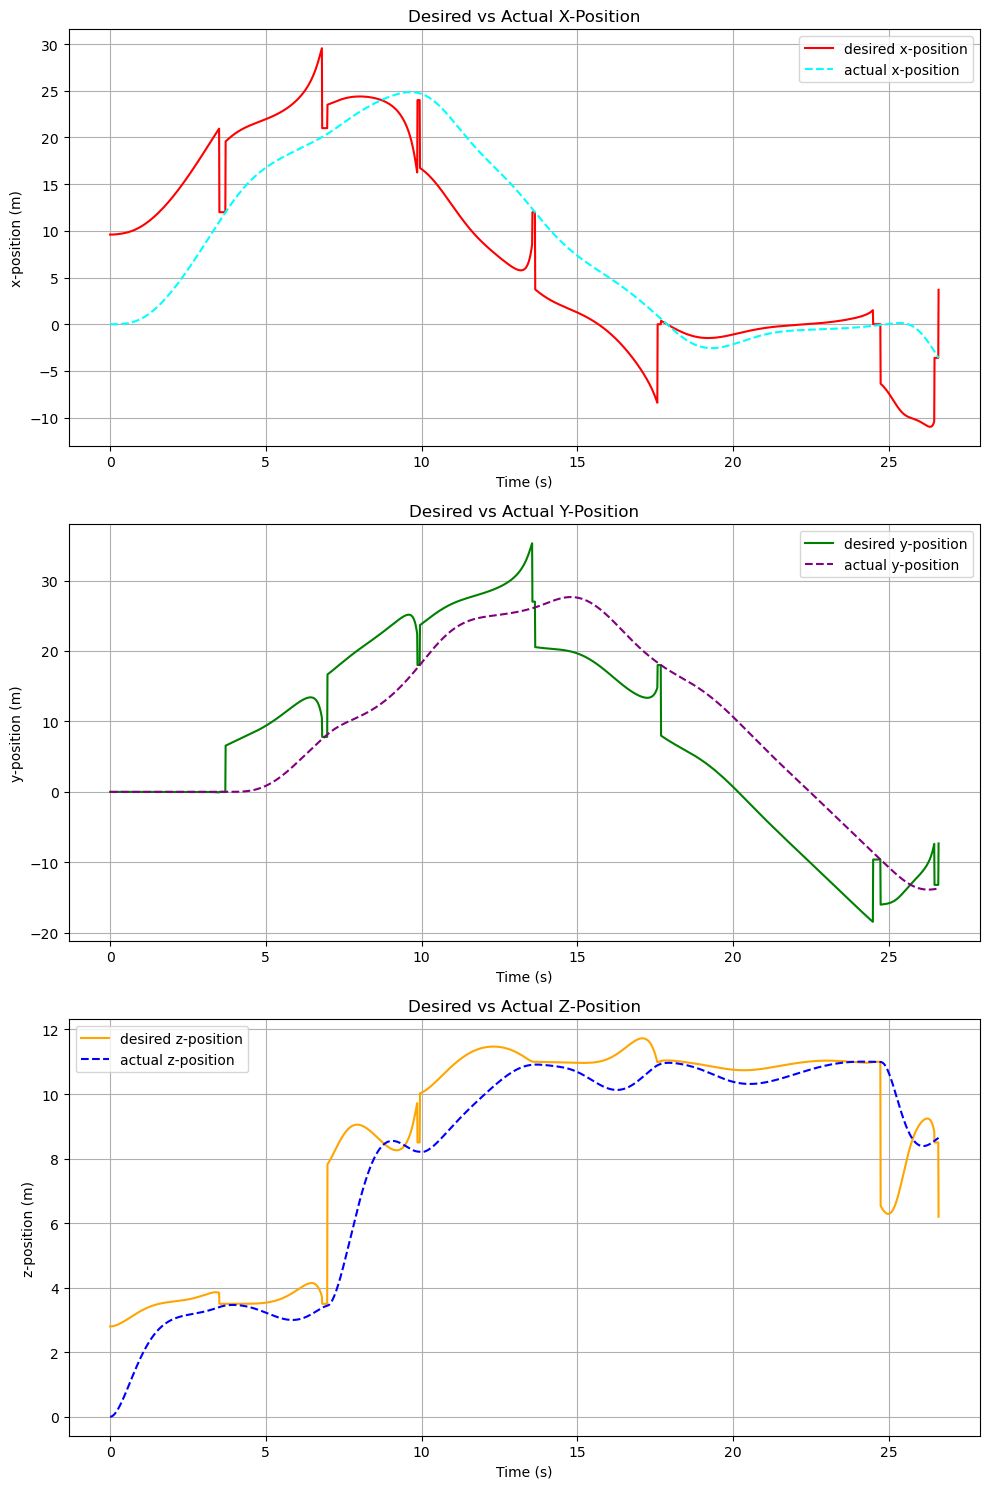

In [42]:
# Setting up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# x-position plot
axs[0].plot(time_test, x_des, label='desired x-position', color='red')
axs[0].plot(time_test, x_act, label='actual x-position', color='cyan', linestyle='--')
axs[0].legend()
axs[0].set_title('Desired vs Actual X-Position')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('x-position (m)')
axs[0].grid(True)

# y-position plot
axs[1].plot(time_test, y_des, label='desired y-position', color='green')
axs[1].plot(time_test, y_act, label='actual y-position', color='purple', linestyle='--')
axs[1].legend()
axs[1].set_title('Desired vs Actual Y-Position')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('y-position (m)')
axs[1].grid(True)

# z-position plot
axs[2].plot(time_test, z_des, label='desired z-position', color='orange')
axs[2].plot(time_test, z_act, label='actual z-position', color='blue', linestyle='--')
axs[2].legend()
axs[2].set_title('Desired vs Actual Z-Position')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('z-position (m)')
axs[2].grid(True)

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.savefig('des-act-pos-data.png', dpi=300, bbox_inches='tight')
plt.show()

The plots above illustrate how the drone was able to follow the desired position of each gate using the gradient descent algorithm. Each spike in the graph represents the change in desired gate position as the drone passes through each one. If the distance between the drone’s actual and desired
position of the gate was greater than 1.0 meter corresponding to the error condition in the controller design, then the control system would moderate the drone’s approach by gradually guiding it towards the gate.

### Competiting Controller Design 

The competing controller design was created using a mirrored version of the original controller without implementation of the gradient descent algorithm. Using the same A,B,C,K,L matrices as the original controller, the controller by itself was able to pass through the first two gates. With this limited drone setup, the race can mimic real-world scenarios where drones may face early obstructions while navigating through their enviornment.

In [44]:
# Create the Controller class
class Controller2():
    def __init__(self):
        self.A = np.array(A, dtype=float)
        self.B = np.array(B, dtype=float)
        self.C = np.array(C, dtype=float)
        self.K = np.array(K, dtype=float)
        self.L = np.array(L, dtype=float)
        self.m_e = np.array([px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e])
        self.n_e = np.array([taux_e, tauy_e, tauz_e, fz_e])
        self.g_eq = g_eq
        self.e_max = 0.7
        pass

    
    def reset(self):
        self.xhat = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        pass
    
    
    def run(self, **kwargs):
        self.dt = kwargs["dt"]
        self.p_des = kwargs["next_gate"]
        self.p_dir = kwargs["dir_gate"]
        self.p_hat = self.xhat[:3]
        
        self.x_des = np.block([self.p_des, np.zeros(9)])

        # calculating gains
        u = - self.K@(self.xhat - self.x_des)
        inputs = u + self.n_e
            
        # last gate condition
        if kwargs["is_last_gate"]:
            inputs = inputs*1.2
        
        sensor = np.block([kwargs["mocap_1"], kwargs["mocap_2"], kwargs["mocap_3"], kwargs["mocap_4"]])
        y = sensor - self.g_eq
        self.xhat += self.dt * (self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat - y))

        return inputs

# Create an instance of our Controller class to simulate 1 quadrotor
controller2 = Controller2()

This set of 100 simulations were conducted with the drones both initially at rest and under Earth’s gravity. The maximum simulation time was again set to 30 seconds, and if the race time exceeded the maximum simulation time, the simulation ended and concluded the race. The sensor noise was set to 0.01 meters. The success of the drone was recorded by using a counter to count the number of times the run time for the drone was less than the simulation run time. 

In [46]:
# Make an instance of the simulator for 1 quadrotor
trials = 100
success_count = 0
fail_count = 0
# Initialize the controller
controller.__init__()
controller2.__init__()
for i in range(1, trials+1):
    # Reset the simulator with initial conditions at equilibirum
    team_list = ["Team Flying Mambas","the ORB"]
    sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=2,
                                        team_list=team_list,
                                        planet="Earth",
                                        use_keyboard=True,
                                        visualization=False,
                                        visualization_fr=45.,
                                        animation=False,
                                        verbose=False)
    # Reset the controller
    controller.reset()
    controller2.reset()
    
    # Run the simulation
    controllers = [controller,controller2]
    (track_stats, data1) = sim.run(controllers,
                              sensor_noise=0.01,
                              collect_data=True,
                              max_time=30.0,
                              verbose=True)


    # collecting simulation successes and failures
    if(data1[0]["time"][-1] < 29):
        success_count += 1
    elif (data1[0]["time"][-1] > 29):
        fail_count += 1

Team Flying Mambas:0 PASSED GATE 1 IN 3.95s
the ORB:1 PASSED GATE 1 IN 4.28s
Team Flying Mambas:0 PASSED GATE 2 IN 6.86s
the ORB:1 PASSED GATE 2 IN 8.32s
Team Flying Mambas:0 PASSED GATE 3 IN 10.04s
Team Flying Mambas:0 PASSED GATE 4 IN 13.74s
Team Flying Mambas:0 PASSED GATE 5 IN 17.74s
Team Flying Mambas:0 PASSED GATE 6 IN 24.77s
Team Flying Mambas:0 PASSED GATE 7 IN 26.64s
Team Flying Mambas:0 COMPLETED LAP IN 26.64s
Team Flying Mambas:0 PASSED GATE 1 IN 3.95s
the ORB:1 PASSED GATE 1 IN 4.28s
Team Flying Mambas:0 PASSED GATE 2 IN 6.86s
the ORB:1 PASSED GATE 2 IN 8.33s
Team Flying Mambas:0 PASSED GATE 3 IN 10.04s
Team Flying Mambas:0 PASSED GATE 4 IN 13.75s
Team Flying Mambas:0 PASSED GATE 5 IN 17.75s
Team Flying Mambas:0 PASSED GATE 6 IN 24.79s
Team Flying Mambas:0 PASSED GATE 7 IN 26.65s
Team Flying Mambas:0 COMPLETED LAP IN 26.65s
Team Flying Mambas:0 PASSED GATE 1 IN 3.95s
the ORB:1 PASSED GATE 1 IN 4.28s
Team Flying Mambas:0 PASSED GATE 2 IN 6.86s
the ORB:1 PASSED GATE 2 IN 8.34

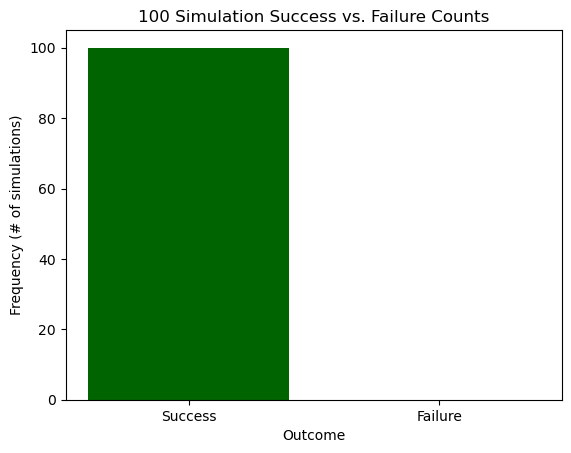

Successes:  100
Failures:  0


In [52]:
labels = ['Success', 'Failure']
totals = [np.sum(success_count), np.sum(fail_count)]
plt.bar(labels, totals, color=['darkgreen', 'red'])
plt.title('100 Simulation Success vs. Failure Counts')
plt.xlabel('Outcome')
plt.ylabel('Frequency (# of simulations)')
plt.savefig('success-failure.png', dpi=300, bbox_inches='tight')
plt.show()

print("Successes: " ,success_count)
print("Failures: ",fail_count)

Seen from the barplot, the number of successes recorded for the dual controller experimentation was 100/100. The controller was successful when racing against another controller. For future work, the second controller could be set with different weights, constants, and algorithms for a more unique racer. Also more controllers could be added to the simulation to explore the original controller's performance limits.